In [77]:
# import sys
# sys.path.append("/Assignments/4Assignment_inverse_problems")
import numpy as np
import matplotlib.pyplot as plt
import general_functions as gf
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

Number of processors: 1, 2, 4, 8, 16, 32, 64, 128

In [3]:
number_of_processors = np.array([1, 2, 4, 8, 16, 32, 64, 128])

In [4]:
# Number of processors to the right
# Measurement repeat down
# time_small: 10000 iterations
# time_medium 1000 iterations
# time_large 500 iterations
# Checksum for small when using 128 processes and 2 nodes changes to 1.60312e+07. 

time_small = np.array([[10.2636, 5.53505, 3.62158, 2.24487, 1.48209, 1.08869, 1.09425, 3.89435],
                    [10.3029, 5.54788, 3.61931, 2.15603, 1.49453, 1.07833, 1.07136, 4.10099],
                    [10.2617, 5.51035, 3.62294, 2.15128, 1.4904, 1.08484, 1.0759, 4.6625]])


time_medium = np.array([[129.979, 82.7279, 77.0288, 92.8574, 70.5342, 16.1425, 10.1966, 2.27325],
                        [130.07, 82.5383, 77.1819, 92.6056, 70.2416, 16.4189, 10.2431, 2.43192]])


time_large = np.array([[253.97, 190.545, 158.236, 191.014, 134.993, 75.6313, 88.2001, 40.4814],
                       [252.309, 189.892, 160.435, 190.438, 134.798, 69.1643, 87.9822, 40.884]])

Get mean, std and relative speedup of data

In [23]:
def error_prop_speedup(t_N_vals, t1, std_t_N_vals, std_t1):
    term1 = std_t1 / t_N_vals
    term2  = -0.5 * t1 / (t_N_vals ** 2) * std_t_N_vals
    std_total = np.sqrt(term1 ** 2 + term2 ** 2)
    return std_total


def abs_rel_speedup_and_efficiecy(data_all, N_processor, weak_scaling=False):
    # Absolute
    abs_speed_mean = np.mean(data_all, axis=0)
    abs_speed_std = np.std(data_all, axis=0) / np.sqrt((len(abs_speed_mean)-1))  # Bessel's correction
    
    # Relative speedup
    # Divide all data points by the ngangs=1 points.
    t1_vals = data_all[:, 0][:, None]
    std_t1_vals = abs_speed_std[0]
    
    rel_speed_data = t1_vals / data_all  # np.divide(data_all.T, data_all[:, 0]).T
    rel_speed_mean = np.mean(rel_speed_data, axis=0)
    rel_speed_std_all = error_prop_speedup(data_all, t1_vals, abs_speed_std, std_t1_vals)
    rel_speed_std = np.mean(rel_speed_std_all, axis=0)
    if weak_scaling:
         rel_speed_mean *= N_processor
         rel_speed_std *= N_processor
    
    # Efficiency
    efficiency_data = t1_vals / (data_all * N_processor)
    efficiency_mean = np.mean(efficiency_data, axis=0)
    efficiency_std = np.std(efficiency_data, axis=0) / np.sqrt(len(efficiency_data) - 1)
    
    return abs_speed_mean, abs_speed_std, rel_speed_mean, rel_speed_std, efficiency_mean, efficiency_std

# Plot

#### Fitting

In [113]:
def amdahl_law_theoretical(N_processor, parallel_fraction):
    """Amdahl's law given the number of processors and the fraction of the program that is parallel."""
    S_latency = 1 / ((1 - parallel_fraction) + parallel_fraction / N_processor)
    return S_latency


def gustafs_law_theoretical(N_processor, parallel_fraction):
    speedup = 1 + (N_processor - 1) * parallel_fraction
    return speedup


def fit_scaling(f_fit, N_processor, time, std_time, p0):
    """_summary_

    Args:
        f_fit (func): Ahmdahls for strong, Gustafs for weak
        time (1darray): Relative time scaling
        std_time (1darray): uncertainty on relative time scaling
        p0 (tupple): Initial guess on parameters

    Returns:
        (par, err, x_fit, y_fit): Fit par, fit err, x values for fit, y values for fit. Last two intended for plotting
    """
    par, cov = curve_fit(f_fit, N_processor, time, sigma=std_time, p0=p0)
    err = np.sqrt(np.diag(cov))
    x_fit = np.linspace(N_processor.min(), N_processor.max(), 300)
    y_fit = f_fit(x_fit, *par)
    return par[0], err[0], x_fit, y_fit

### Plot the strong and week scaling together with fits

In [114]:
def plot_strong_scaling(time_data_sets, N_processor, labels=[]):
    if len(labels) == 0:
        labels = [""] * len(time_data_sets)
    
    # Plot setup
    fig, ax = plt.subplots(nrows=3)

    # All axis setup
    for axis in ax:
        axis.grid()    
        axis.set_xticks(ticks=N_processor, labels=N_processor, fontsize=6)

    # Absolute setup
    ax[0].set(ylabel="Time [s]")
    # Relative setup
    #yticks_rel = np.round(np.linspace(N_processor.min(), N_processor.max(), 10), 1)
    ylim_rel = (0, N_processor.max())
    ax[1].set(ylabel="Speedup", ylim=ylim_rel)
    # ax[1].set_yticks(ticks=yticks_rel, labels=yticks_rel, fontsize=6)
    # Efficiency setup
    ax[2].set(ylabel="Efficiency", xlabel="Processors")
    ax[2].set_xticks(ticks=N_processor, labels=N_processor, fontsize=6)
    
    # Plot ideal lines
    ax[1].plot(N_processor, N_processor, ls="-", color="grey", lw=2)  # Relative scaling ideal 
    ax[2].axhline(1, ls="-", color="grey", lw=2)  # Efficiency ideal 

    # Loop over each time data set and plot it
    for time_data, label in zip(time_data_sets, labels):
        # Get data
        abs_speed_mean, abs_speed_std, rel_speed_mean, rel_speed_std, efficiency_mean, efficiency_std = abs_rel_speedup_and_efficiecy(time_data, N_processor, weak_scaling=False)
        # Plot - Abs, rel, efficiency
        ax[0].errorbar(N_processor, abs_speed_mean, yerr=abs_speed_std, fmt=".--", label=label)  # Absolute scaling
        
        ax[1].errorbar(N_processor, rel_speed_mean, yerr=rel_speed_std, fmt=".--", label=label)  # Relative scaling
    
        ax[2].errorbar(N_processor, efficiency_mean, yerr=efficiency_std, fmt=".--", label=label)  # Efficiency scaling
        
        # Fit and print results
        par, err, x_fit, y_fit = fit_scaling(amdahl_law_theoretical, N_processor, rel_speed_mean, rel_speed_std, p0=(0.20,))
        print(f"{label} - Parallelization frac = {par:.4f} +- {err:.4f}")
        
    
    # Only show a single fit
    ax[1].plot(x_fit, y_fit, ls="-", c="deepskyblue", label=label+" Fit")  # Rel scaling fit
    
    # Legend
    custom_lines = [Line2D([0], [0], color="rebeccapurple", ls="-", marker="."),
                    Line2D([0], [0], color="firebrick", ls="-", marker="."),
                    Line2D([0], [0], color="black", ls="-", marker="."),
                    Line2D([0], [0], color="deepskyblue", ls="-"),
                    Line2D([0], [0], color="grey", ls="-", lw=2),]
    
    labels = labels + ["Fit"] + ["Ideal"]
    fig.legend(custom_lines, labels, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=len(labels))
    fig.savefig("strong_scaling.png")
    plt.show()

Small - Parallelization frac = 0.9072 +- 0.0094
Medium - Parallelization frac = 0.4713 +- 0.0936
Large - Parallelization frac = 0.5004 +- 0.0836


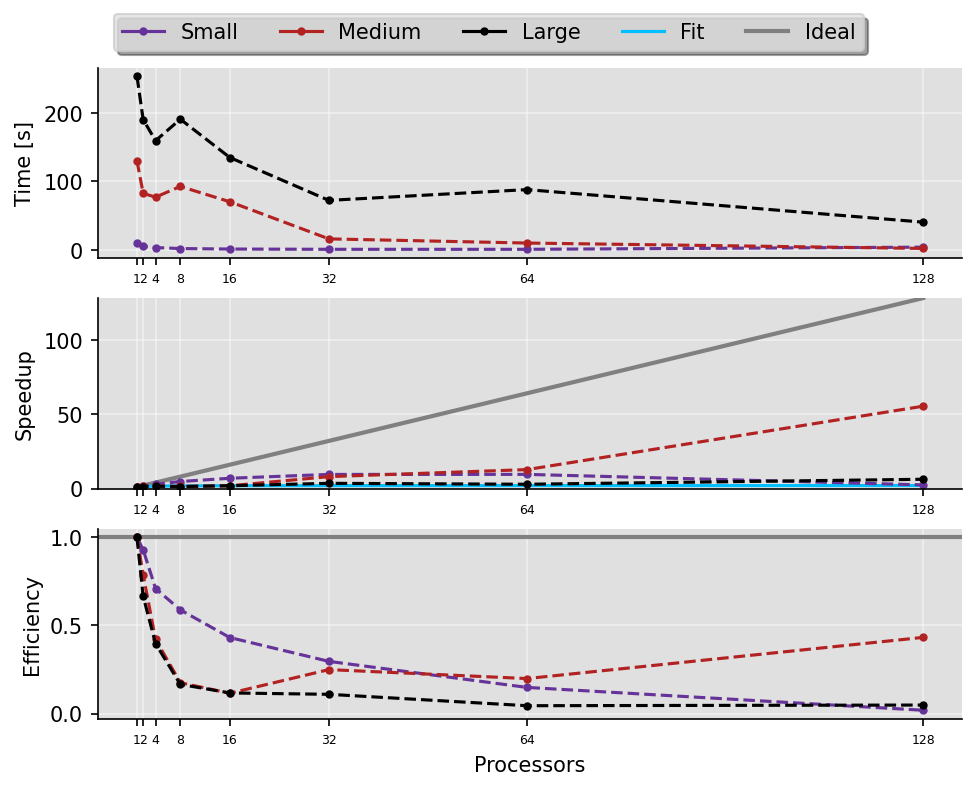

In [115]:
plot_strong_scaling((time_small, time_medium, time_large), number_of_processors, labels=["Small", "Medium", "Large"])